## Project 2. Song recommendation system
#### Song recommendation
* Start with basic song data
* Test out multiple approaches - cosine similarity, KNN
* Try to incorporate lyrics data
* Try to incorporate more metadata
* Try to incorporate user playlist data / collaborative filtering / etc

#### Genre classification
* or key classification
* or song stat regression (as in how joyful is a song likely to be from an artist, in a key, with a bpm, from a year)

#### dataset information
* https://www.kaggle.com/datasets/maharshipandya/-spotify-tracks-dataset
* Key: 0 = C, 1 = C♯/D♭, 2 = D, if no key: -1
* mode: the modality of scale 1 is Major, 0 is minor
* valence - musical positiveness. high (1.0) = happy / cheerful / euphoric, sad(0.0) = sad / depressed / angry
* time signature - time signature by 4, eg 3/4, 4/4, ranges from 3 to 7
* loudness - overall loudness in dB

In [51]:
import pandas as pd
import numpy as np
import math
import sklearn
import plotly.express as px
import plotly
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [7]:
df = pd.read_csv('../datasets/spotify_songs.csv', index_col = 0)
# with engineered features, cleanup etc
df_eng = pd.read_csv('../datasets/spotify_songs_eng.csv', index_col = 0)

### Dataset exploration

In [3]:
df.sample(5)

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
102999,4KROoGIaPaR1pBHPnR3bwC,Nick Drake,Pink Moon,Pink Moon,69,124000,False,0.642,0.427,3,-8.471,1,0.0402,0.8710,0.090400,0.1240,0.4040,82.344,4,songwriter
43321,6IfOFGLpJmYSyrKed5N3gk,Rogér Fakhr,Fine Anyway (Habibi Funk 016),Fine Anyway,52,163437,False,0.602,0.390,4,-9.198,0,0.0408,0.8480,0.000250,0.1140,0.4840,62.470,4,groove
102285,21i2PhBdDKSlJ5gJZl2M7V,Chicago,Holly Jolly Christmas,(Because) It's Christmastime,0,200026,False,0.711,0.742,11,-5.434,0,0.0294,0.1720,0.000838,0.0502,0.7300,100.053,4,songwriter
17127,1d6BkMki9M6K0yp9OLBzOM,Actress,Karma & Desire,Fire and Light,57,75969,False,0.337,0.280,0,-18.646,0,0.0384,0.9870,0.882000,0.0851,0.0824,140.004,4,club
27330,1Jf5PyufpsLNeeMF32zHJ8,SHY FX;T. Power,Diary of a Digital Soundboy,Sheets,19,297533,False,0.356,0.902,9,-2.658,0,0.0578,0.0228,0.060000,0.2940,0.4490,89.995,4,drum-and-bass


In [4]:
df.describe()

,popularity,duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
count,114000.000000,1.140000e+05,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000,114000.000000
mean,33.238535,2.280292e+05,0.566800,0.641383,5.309140,-8.258960,0.637553,0.084652,0.314910,0.156050,0.213553,0.474068,122.147837,3.904035
std,22.305078,1.072977e+05,0.173542,0.251529,3.559987,5.029337,0.480709,0.105732,0.332523,0.309555,0.190378,0.259261,29.978197,0.432621
min,0.000000,0.000000e+00,0.000000,0.000000,0.000000,-49.531000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,17.000000,1.740660e+05,0.456000,0.472000,2.000000,-10.013000,0.000000,0.035900,0.016900,0.000000,0.098000,0.260000,99.218750,4.000000
50%,35.000000,2.129060e+05,0.580000,0.685000,5.000000,-7.004000,1.000000,0.048900,0.169000,0.000042,0.132000,0.464000,122.017000,4.000000
75%,50.000000,2.615060e+05,0.695000,0.854000,8.000000,-5.003000,1.000000,0.084500,0.598000,0.049000,0.273000,0.683000,140.071000,4.000000
max,100.000000,5.237295e+06,0.985000,1.000000,11.000000,4.532000,1.000000,0.965000,0.996000,1.000000,1.000000,0.995000,243.372000,5.000000


In [5]:
df.isnull().sum()

track_id            0
artists             1
album_name          1
track_name          1
popularity          0
duration_ms         0
explicit            0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
time_signature      0
track_genre         0
dtype: int64

1 or 2 rows with empty data, no problem with dropping them

In [12]:
df = df.dropna()

In [14]:
# df.to_csv('../datasets/spotify_songs_eng.csv')

In [6]:
df.nunique()

track_id            89741
artists             31437
album_name          46589
track_name          73608
popularity            101
duration_ms         50697
explicit                2
danceability         1174
energy               2083
key                    12
loudness            19480
mode                    2
speechiness          1489
acousticness         5061
instrumentalness     5346
liveness             1722
valence              1790
tempo               45653
time_signature          5
track_genre           114
dtype: int64

#### finding duplicates - new dataset variable 'df_eng'

In [19]:
duplicated = df.duplicated(subset=['track_id'])

In [20]:
duplicated

0         False
1         False
2         False
3         False
4         False
          ...  
113995    False
113996    False
113997    False
113998    False
113999    False
Length: 113999, dtype: bool

In [26]:
dup_df = df[duplicated].sort_values(by=['track_id'])

In [28]:
dup_df.head()

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
103211,001APMDOl3qtx1526T11n1,Pink Sweat$;Kirby,New RnB,Better,0,176320,False,0.613,0.471,1,-6.644,0,0.1070,0.31600,0.000001,0.1170,0.406,143.064,4,soul
100420,001YQlnDSduXd5LgBd66gT,Soda Stereo,Soda Stereo (Remastered),El Tiempo Es Dinero - Remasterizado 2007,38,177266,False,0.554,0.921,2,-4.589,1,0.0758,0.01940,0.088100,0.3290,0.700,183.571,1,ska
91801,003vvx7Niy0yvhvHt4a68B,The Killers,Hot Fuss,Mr. Brightside,86,222973,False,0.352,0.911,1,-5.230,1,0.0747,0.00121,0.000000,0.0995,0.236,148.033,4,rock
3257,003vvx7Niy0yvhvHt4a68B,The Killers,Hot Fuss,Mr. Brightside,86,222973,False,0.352,0.911,1,-5.230,1,0.0747,0.00121,0.000000,0.0995,0.236,148.033,4,alternative
94239,004h8smbIoAkUNDJvVKwkG,Ouse;Powfu,Loners Diary,Lovemark,58,219482,True,0.808,0.331,5,-13.457,1,0.0557,0.13100,0.000000,0.2250,0.337,140.035,4,sad


In [29]:
df_eng = df.drop_duplicates(subset=['track_id'], keep='first')

In [32]:
df_eng = df_eng.reset_index()

#### data distributions

In [8]:
df_eng.dtypes

track_id             object
artists              object
album_name           object
track_name           object
popularity            int64
duration_ms           int64
explicit               bool
danceability        float64
energy              float64
key                   int64
loudness            float64
mode                  int64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
time_signature        int64
track_genre          object
dtype: object

#### True / False to int

In [9]:
df_eng['explicit'] = df_eng['explicit'].astype(int)

#### Selecting numerical columns

In [10]:
cols_no_index = [col for col in df_eng.columns if col != 'index']
cols_no_index

['track_id',
 'artists',
 'album_name',
 'track_name',
 'popularity',
 'duration_ms',
 'explicit',
 'danceability',
 'energy',
 'key',
 'loudness',
 'mode',
 'speechiness',
 'acousticness',
 'instrumentalness',
 'liveness',
 'valence',
 'tempo',
 'time_signature',
 'track_genre']

In [11]:
numerical_cols = [col for col in cols_no_index if df[col].dtype in ['int64', 'float64', 'int32']]
numerical_cols

['popularity',
 'duration_ms',
 'danceability',
 'energy',
 'key',
 'loudness',
 'mode',
 'speechiness',
 'acousticness',
 'instrumentalness',
 'liveness',
 'valence',
 'tempo',
 'time_signature']

In [12]:
len(numerical_cols)

14

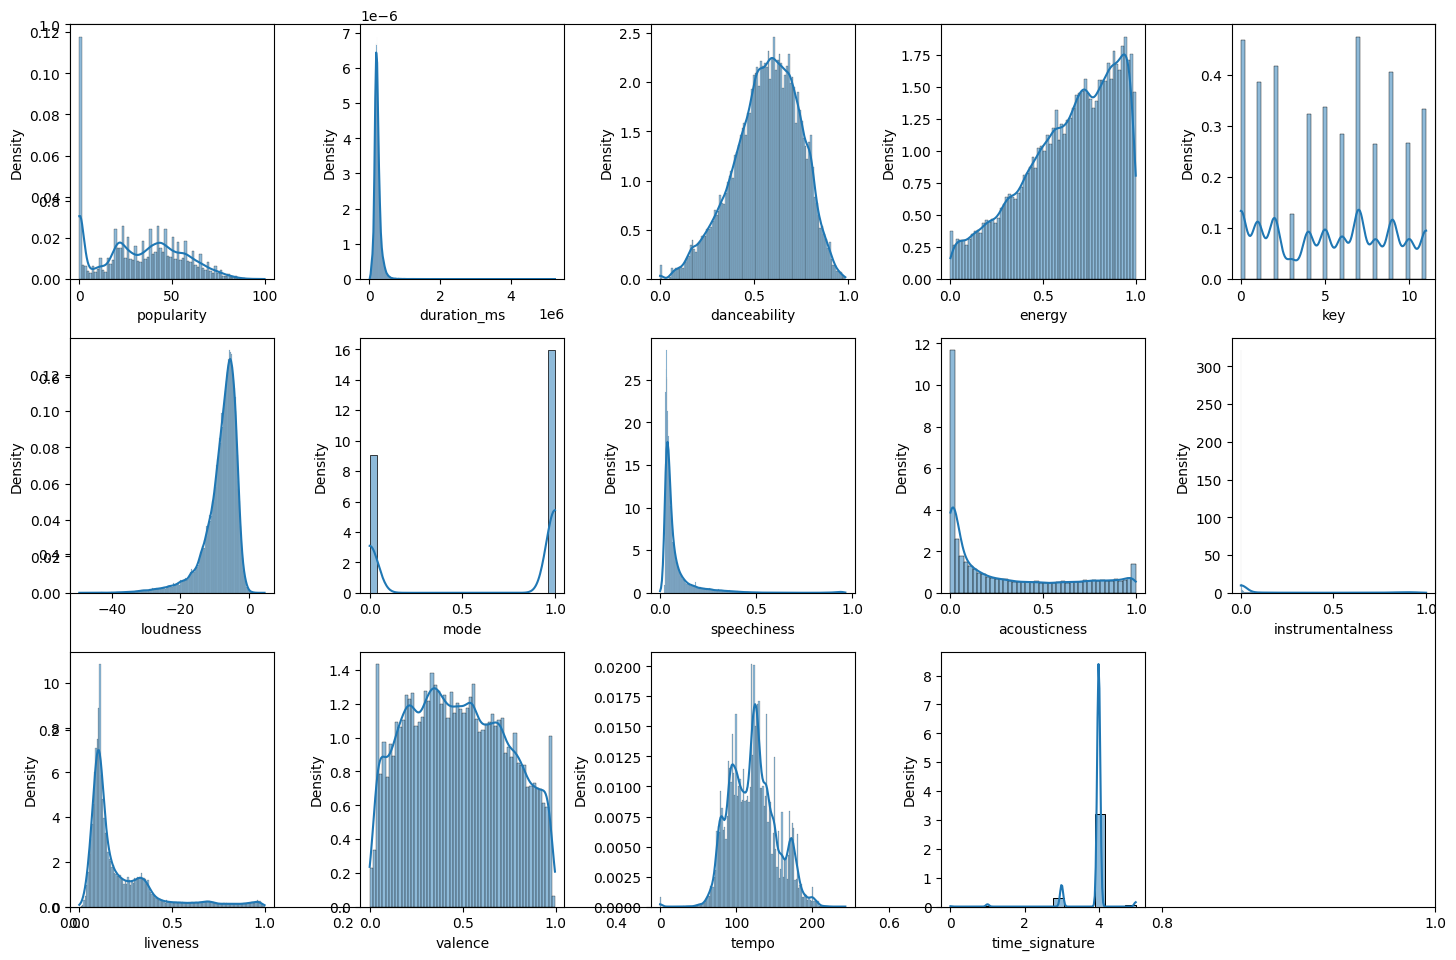

In [13]:
plt.subplots(figsize = (15,10))
for i, col in enumerate(numerical_cols):
    plt.subplot(3,5, i+1)
    sns.histplot(df_eng[col], kde=True, stat="density")
    # sns.histplot(df_eng[col], kde=True)
plt.tight_layout()
plt.show()

#### Some distribution notes
* Should songs with instrumentalness, acousticness or speechiness of 0 be removed? They could legitimately have those statistics
* Other than the mentioned 0s no significant outliers seem to be present, maybe some in the duration_ms section
* 

In [64]:
df_eng['duration_ms'].sort_values(ascending=False).head(5)

61360    5237295
10201    4789026
22992    4730302
61582    4563897
12508    4447520
Name: duration_ms, dtype: int64

Let's look at some of the longest songs in the dataset, as 5237295ms is over 1400 hours long!

In [65]:
df_eng[df_eng['duration_ms'] > 4000000]

,index,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
10201,10935,0LBIf9EFHuxmuNig4JHGZo,Timo Maas,Crossing Wires 002 - Compiled And Mixed By Tim...,Crossing Wires 002 - Continuous DJ Mix,11,4789026,0,0.6970,0.632,...,-12.469,1,0.0451,0.00815,0.8710,0.0998,0.15100,121.055,4,breakbeat
12359,13195,3se0UYprtkHthJEBuk1A5K,Mark Farina,Greenhouse Construction,Greenhouse Construction,12,4334721,0,0.8460,0.744,...,-9.260,0,0.0611,0.00371,0.3350,0.3130,0.53200,125.434,4,chicago-house
12409,13245,13hQAhg1owjTpTcI9xQc6c,Mark Farina,Live In Tokyo,Live In Tokyo - Continuous Mix,11,4339826,0,0.8060,0.582,...,-12.181,1,0.0874,0.00830,0.2370,0.3280,0.68600,128.368,4,chicago-house
12508,13344,3gFme8BdfTtFHxKmuTnSbj,Mark Farina,House of OM (DJ Mix),House of Om - Mark Farina - Continuous Mix,11,4447520,0,0.8610,0.805,...,-6.461,0,0.0711,0.00548,0.5770,0.1350,0.54500,129.306,4,chicago-house
22992,24348,6wypxnAvmv5zYewUX3VFDd,Seth Troxler,Seth Troxler - The Lab 03,The Lab 03 - Continuous DJ Mix Part 1,8,4730302,0,0.6840,0.656,...,-11.163,0,0.0633,0.01910,0.8480,0.1030,0.30100,123.180,4,detroit-techno
26429,27926,6eTDnsdPlRUyrTHqFj3l7W,Lenzman;Dan Stezo,NQ State of Mind,"NQ State of Mind, Vol. 1 - Continuous DJ Mix",15,4246206,1,0.5930,0.924,...,-3.979,1,0.0899,0.00369,0.0221,0.5340,0.24200,173.938,4,drum-and-bass
61360,73617,3Cnz3Bu9Wcw8p3kiBTXTxp,Tale Of Us,Unity (Voyage Mix),Unity (Voyage Mix) Pt. 1,35,5237295,0,0.6950,0.736,...,-11.371,0,0.0374,0.00399,0.8600,0.0910,0.05090,124.001,4,minimal-techno
61582,73840,6JbQr97EMFD2D3Ek6gxgt1,Loco Dice,Amnesia Ibiza - Underground 10,Amnesia Ibiza Underground 10 DJ Mix,17,4563897,0,0.7830,0.728,...,-10.176,0,0.0612,0.00158,0.8400,0.1580,0.18900,125.044,4,minimal-techno
80325,101390,2QfFLpSGF1T1pY6tq4kD7Z,Ocean Sounds,Ocean Waves Sounds to Relax and Sleep,Ocean Waves Sounds,39,4120258,0,0.0797,0.995,...,-17.379,1,0.0612,0.93200,0.5620,0.3100,0.00001,84.788,3,sleep


Tracks like 'continuous mix' do appear like legitimate entrances. They shall be considered in later tasks. In case of a recommendation system considering the song durations as a feature, due to how extreme their duraton values are, they are likely to only be considered together.

### Similarity finding

#### Using KNN and euclidean distance

#### Querying functions
* knnQuery - find k most similar songs
* rangeQuery - find songs within radius of similarity from the query point, with the query point defined by the index of the song

In [18]:
# K-query
def knnQuery(queryPoint, arrCharactPoints, k):
    """
    Calculates the distance of supplied song index
    ---
    Arguments:
        queryPoint - chosen song index from the df_eng dataframe
        arrCharactPoints - index to consider for distance calculation
        k - the number of closest songs to return
    Returns:
        np array of song indexes
    """
    tmp = arrCharactPoints.copy(deep=True)
    tmp['dist'] = tmp.apply(lambda x: np.linalg.norm(x-queryPoint), axis=1)
    tmp = tmp.sort_values('dist')
    return tmp.head(k).index

# K-query
# with distances included
def knnQueryFull(queryPoint, arrCharactPoints, k):
    """
    Calculates the distance of supplied song index
    ---
    Arguments:
        queryPoint - chosen song index from the df_eng dataframe
        arrCharactPoints - index to consider for distance calculation
        k - the number of closest songs to return
    Returns:
        list of tuples of structure [ (song_index, distance), (index, distance), ...] of len k
    """
    tmp = arrCharactPoints.copy(deep=True)
    tmp['dist'] = tmp.apply(lambda x: np.linalg.norm(x-queryPoint), axis=1)
    tmp = tmp.sort_values('dist')
    return_idx = list(tmp.head(k).index)
    return_dist = tmp.head(k)['dist'].values
    return_list = [(index, dist) for index, dist in zip(return_idx, return_dist)]
    return return_list

# Range query
def rangeQuery(queryPoint, arrCharactPoints, radius):
    tmp = arrCharactPoints.copy(deep=True)
    tmp['dist'] = tmp.apply(lambda x: np.linalg.norm(x-queryPoint), axis=1)
    tmp['radius'] = tmp.apply(lambda x: 1 if x['dist'] <= radius else 0, axis=1)
    return tmp.query('radius == 1').index

#### Function to execute the chosen query with the chosen song index, returns songs satisfying the chosen query condition

In [19]:
# Execute k-NN removing the 'query point'
def querySimilars(df, columns, idx, func, param):
    """
    Executes the supplied func query by removing the input song by index (idx),
    considering only the selected df columns, with param being k or range threshold
    response = func(queryPoint, arr, param)
    returns response based on supplied func function
    """
    arr = df[columns].copy(deep=True)
    queryPoint = arr.loc[idx]
    arr = arr.drop([idx])
    response = func(queryPoint, arr, param)
    return response

### Function to sample n random songs and their indexes

In [37]:
def sample_n_songs(df, n):
    sample_songs = df.sample(n)
    sample_songs_names = sample_songs['track_name'].values
    sample_songs_idx = list(sample_songs.index)
    return sample_songs, sample_songs_names, sample_songs_idx

In [38]:
sample_songs, sample_songs_names, sample_songs_idx = sample_n_songs(df_eng, 10)

In [39]:
sample_songs_idx

[4346, 25389, 68888, 32939, 9523, 9258, 39003, 74140, 94175, 86998]

In [40]:
sample_songs

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
4346,1vTkNAelvP5V2vbQ5rAbu3,Max Richter;Elena Urioste;Chineke! Orchestra,Antonio Vivaldi - Inspiring Classics,"Recomposed By Max Richter: Vivaldi, The Four S...",11,92087,0,0.327,0.4050,5,-13.561,1,0.0538,0.8390,0.96500,0.0744,0.478,165.180,3,ambient
25389,6uopsC7wCZfSZc4TfyjazT,Almklausi,Ballermann Party Mix - Alle Après Ski Hütten H...,Eine Skifahrt die ist lustig,0,190014,0,0.696,0.9890,11,-3.711,1,0.1300,0.0421,0.00000,0.4130,0.516,141.039,4,disco
68888,06aqptFP9n0y4pPTQOEWKr,Vuelta Canela,Juegos Canelos,Una Nube,41,157219,0,0.705,0.0715,0,-23.231,1,0.6420,0.7940,0.00000,0.7770,0.713,115.326,4,latino
32939,4PuvBMm0y4klls9NCg8lxl,HXE,Drop That MF,Drop That MF,33,116006,1,0.947,0.1930,7,-12.119,1,0.4820,0.0181,0.36800,0.1110,0.135,129.985,4,electronic
9523,3vddabBsXcvoerPkIlDHDF,Central 3;André Aquino,Tudo a Ver Com Ele (Ao Vivo),Tudo a Ver Com Ele - Ao Vivo,46,429127,0,0.372,0.6580,7,-6.531,1,0.0404,0.3290,0.00000,0.6880,0.212,136.975,4,brazil
9258,1ACPXBpp4m1okYEiUkYfcU,Colo de Deus,"O Cordeiro, o Leão e o Trono - Parte 1 (Ao Vivo)",Desperta - Ao Vivo,47,460040,0,0.400,0.6850,1,-6.752,0,0.0566,0.6960,0.00000,0.7020,0.147,138.941,4,brazil
39003,5jyPgh9K0YlyhlVGQzFsbO,Robin Schulz;David Guetta,House Anthems,On Repeat,5,190217,0,0.609,0.8010,1,-8.483,0,0.0694,0.0246,0.00255,0.3700,0.202,122.958,4,german
74140,5J46ZclMEseJiZklYTs1fB,Milton Nascimento;Chico Buarque,Fiesta temática 70s,O Que Será (A Flor Da Pele),0,247426,0,0.431,0.3660,4,-12.371,0,0.0354,0.6890,0.00000,0.4340,0.258,112.096,4,mpb
94175,5KPSKv02jtAsI7fmpT7enC,me7k,Is It Too Much to Ask For,Is It Too Much to Ask For,62,100586,0,0.901,0.4670,10,-9.142,1,0.0586,0.0500,0.01530,0.1050,0.580,105.586,4,sad
86998,6zpBjeIne0jS2AVCElureG,Kapelle Petra,Nackt,Also stoßen wir an,37,235152,0,0.409,0.8130,3,-4.346,1,0.0376,0.0138,0.00000,0.1830,0.480,188.115,4,punk


#### Querying by number of songs

In [22]:
# Selecting query parameters
func, param = knnQuery, 5 # k=5

# Querying
response = querySimilars(df_eng, numerical_cols, sample_songs_idx[0], func, param)

print("Querying:")
print(sample_songs_idx[0], df_eng.loc[sample_songs_idx[0]]['track_name'])
print("Similar songs:")
for idx in response:
    track_name = df_eng.loc[idx]['track_name']
    print(idx, track_name)

Querying:
87726 Maio - Ao Vivo
Similar songs:
74726 Maio - Ao Vivo
43773 Am I Dreaming (feat. Megan Brands)
23828 Am I Dreaming (feat. Megan Brands)
106906 Ruin My Life - Steve James Remix
36815 ADDICTIONS


Querying by range threshold  
Doesn't seem to be working

In [80]:
# Selecting query parameters
func, param = rangeQuery, 0.5 # threshold distance
# Querying
response = querySimilars(df_eng, numerical_cols, sample_songs_idx[1], func, param)

print("Querying:")
print(sample_songs_idx[1], df_eng.loc[sample_songs_idx[1]]['track_name'])
print("Similar songs:")
for idx in response:
    track_name = df_eng.loc[idx]['track_name']
    print(idx, track_name)

Querying:
56181 Casper The Friendly Ghost
Similar songs:


#### Function to knn query by song index and return similar song indexes

In [23]:
def query_by_song(song_idx, df, columns, k):
    """
    Utilizes knnQuery, knnQueryFull and querySimilars to query similar songs by input song index,
    calculating the distance by selected columns
    returns a dataframe with the queried song and k similar songs, marking the query song with 'is_query' = 1
    ---
    Arguments:
        song_idx - query song index
        df - source dataframe
        columns - selected columns
        k - how many songs to return in the result dataframe
    """
    # Selecting query parameters
    func, param = knnQueryFull, k
    # Querying
    response = querySimilars(df, numerical_cols, song_idx, func, param)
    
    print("Querying:")
    print(song_idx, df.loc[song_idx]['track_name'])
    # print("Query song stats:")
    # print(df.loc[song_idx])
    # print("Similar songs:")

    input_song = df.loc[song_idx]
    similar_songs = pd.DataFrame(input_song).T
    similar_songs['dist'] = 0
    similar_songs['is_query'] = 1
    similar_songs
    
    for resp in response:
        idx = resp[0]
        dist = resp[1]
        track_name = df.loc[idx]['track_name']
        track = df.loc[idx]
        track_df = pd.DataFrame(track).T
        track_df['dist'] = dist
        track_df['is_query'] = 0
        similar_songs = pd.concat([similar_songs, track_df])
        print(f'idx: {idx}, track: {track_name}, dist: {dist}')
    
    return similar_songs

In [96]:
# dft1 = pd.DataFrame(df_eng.loc[25671]).T

In [95]:
# dft2 = pd.DataFrame(df_eng.loc[25672]).T

In [94]:
# dft1 = pd.concat([dft1, dft2])

In [93]:
# dft1

In [24]:
test_song_idx = df_eng.sample(1).index.values[0]
test_song_idx

75034

In [28]:
test_similar_songs = query_by_song(test_song_idx, df_eng, numerical_cols, 10)

Querying:
75034 Believe - From "The Polar Express"
idx: 79189, track: Believe - From "The Polar Express", dist: 0.0
idx: 23347, track: Breeze, dist: 44.20502406062008
idx: 27680, track: Hail Up The Lion, dist: 46.96126996122121
idx: 10276, track: Hail Up The Lion, dist: 46.96126996122121
idx: 61279, track: 夕陽1/3, dist: 49.238059649421615
idx: 46191, track: Forever Young - Paul Says MERRY XMESS Bootleg, dist: 65.44413250849864
idx: 54855, track: Headwind, dist: 65.46698616860257
idx: 50468, track: Minä olen, dist: 66.28990266986615
idx: 17805, track: Fuschia, dist: 68.01429255744709
idx: 111620, track: Fixed Income, dist: 69.87915813388138


In [29]:
test_similar_songs

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,...,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre,dist,is_query
75034,1tTjmC6FSSFE04FkNpa3xJ,Jim Brickman,Christmas Faves 2022,"Believe - From ""The Polar Express""",0,289053,0,0.364,0.11,4,...,0.0771,0.985,0.924,0.111,0.15,196.58,3,new-age,0.000000,1
79189,1tTjmC6FSSFE04FkNpa3xJ,Jim Brickman,Christmas Faves 2022,"Believe - From ""The Polar Express""",0,289053,0,0.364,0.11,4,...,0.0771,0.985,0.924,0.111,0.15,196.58,3,piano,0.000000,0
23347,6oTwOCKqIGCSHsO5KJit9V,Axero,Energetic Takeoff EDM,Breeze,0,289090,0,0.514,0.802,9,...,0.0313,0.0416,0.522,0.106,0.295,176.088,4,deep-house,44.205024,0
27680,3RDWPnDrE0GTOaYTqpeX3X,Ed Solo;Deekline,No No No,Hail Up The Lion,16,289090,0,0.634,0.891,7,...,0.0522,0.000197,0.000167,0.182,0.537,176.02,4,drum-and-bass,46.961270,0
10276,3RDWPnDrE0GTOaYTqpeX3X,Ed Solo;Deekline,No No No,Hail Up The Lion,16,289090,0,0.634,0.891,7,...,0.0522,0.000197,0.000167,0.182,0.537,176.02,4,breakbeat,46.961270,0
61279,3L5vwQmbLivfbimSTkx5fG,Keyakizaka46,真っ白なものは汚したくなる (Complete Edition),夕陽1/3,25,289066,0,0.416,0.867,6,...,0.0423,0.115,0.0,0.338,0.822,158.989,4,j-idol,49.238060,0
46191,5dCXXvJg4sJBPErwZiWhCW,Paul Elstak,b2s Presents Paul Elstak,Forever Young - Paul Says MERRY XMESS Bootleg,24,289106,0,0.414,0.979,7,...,0.152,0.025,0.000003,0.299,0.0765,169.976,4,happy,65.444133,0
54855,4anysyWdzzghWjZxDeXbce,Lusine,Language Barrier,Headwind,11,289106,0,0.41,0.526,7,...,0.0371,0.049,0.944,0.281,0.227,160.005,4,idm,65.466986,0
50468,7lltIP2aLYnEwbrKdYq0gb,Kotiteollisuus,Helvetistä itään,Minä olen,23,289013,0,0.425,0.947,4,...,0.0483,0.000018,0.883,0.331,0.376,151.009,4,heavy-metal,66.289903,0
17805,1G950qfSStXZLjScolxmmv,Dark0,Solace,Fuschia,16,289018,0,0.786,0.461,7,...,0.0841,0.0597,0.941,0.138,0.252,142.04,4,club,68.014293,0


In [30]:
test_similar_songs['dist'].mean()

47.49637233370727

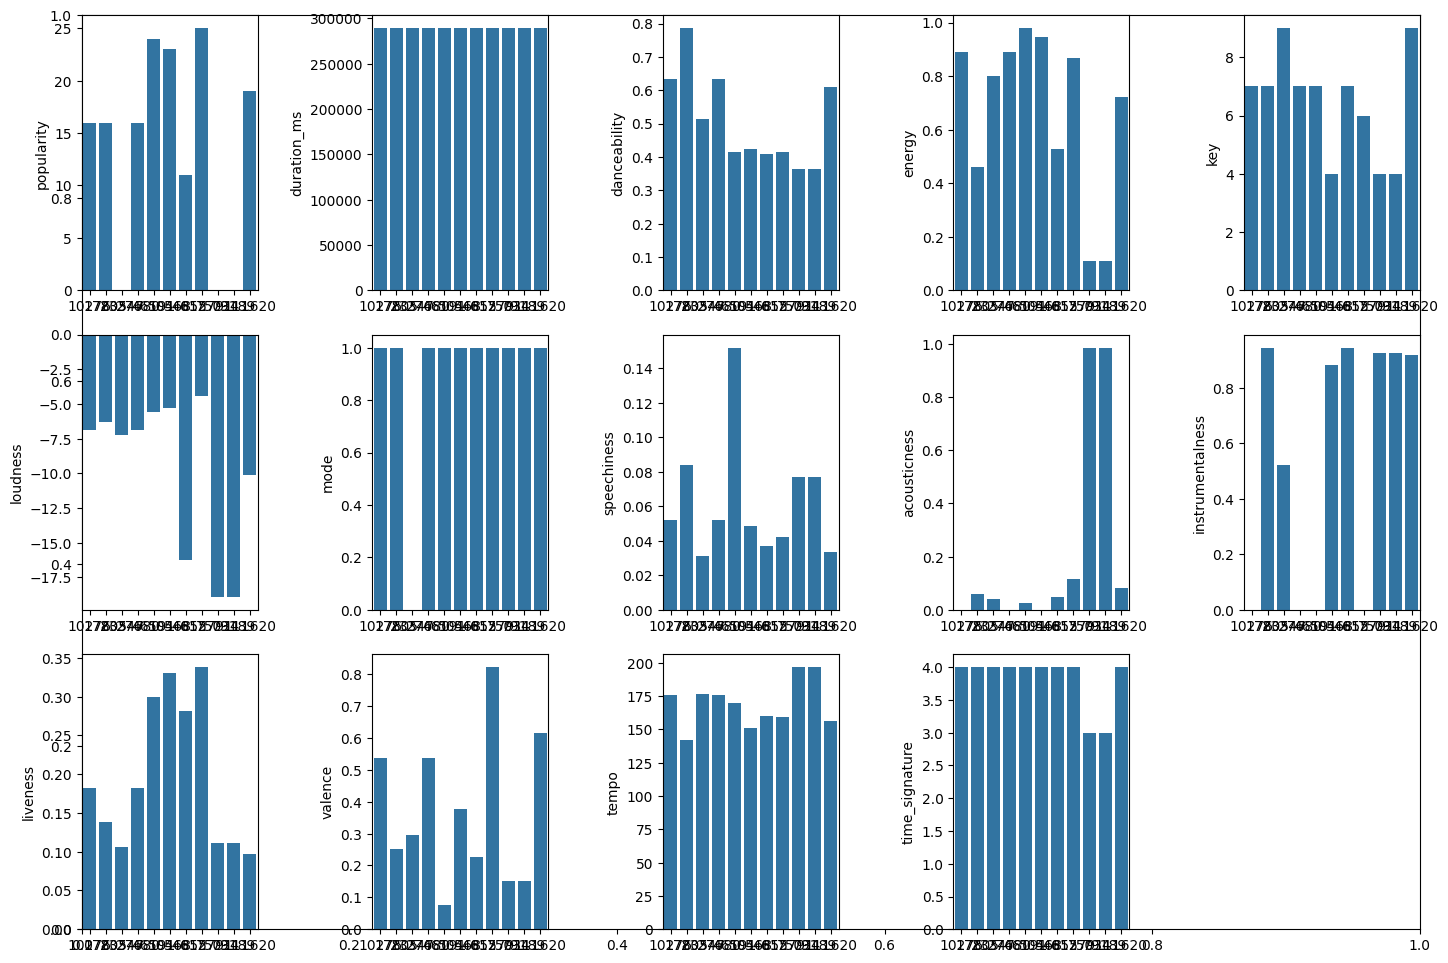

In [31]:
plt.subplots(figsize = (15,10))
for i, col in enumerate(numerical_cols):
    plt.subplot(3,5, i+1)
    # sns.histplot(df_eng[col], kde=True, stat="density")
    # sns.histplot(df_eng[col], kde=True)
    sns.barplot(test_similar_songs[col])
plt.tight_layout()
plt.show()

Interestlingly, we got songs from many genres, with one repeated artist, with a wide range of song charactristics, with the only uniformity in song duration

#### Testing for more songs
To see if some more relations / distributions can be noticed, particularly in terms of calculated song distance and its relation with other stats, depending on the input song

In [44]:
sample_songs, sample_songs_names, sample_songs_idx = sample_n_songs(df_eng, 10)
results_10_df = pd.DataFrame()
for song_idx in sample_songs_idx:
    song_results = query_by_song(song_idx, df_eng, numerical_cols, 10)
    results_10_df = pd.concat([results_10_df, song_results])
results_10_df = results_10_df.reset_index(drop=True)

Querying:
51282 Satisfy
idx: 8823, track: Joker And The Thief, dist: 18.658243196239024
idx: 38242, track: Joker And The Thief, dist: 18.658243196239024
idx: 84379, track: Joker And The Thief, dist: 18.658243196239024
idx: 113355, track: Here For You - Live, dist: 22.716755677913167
idx: 2202, track: Boku no Sensou, dist: 28.546880627935504
idx: 3355, track: Boku no Sensou, dist: 28.546880627935504
idx: 63009, track: Boku no Sensou, dist: 28.546880627935504
idx: 74815, track: Janaina, dist: 33.349351271823096
idx: 41188, track: Glory, Amen, dist: 40.531586366191
idx: 9304, track: Luz em Todo Morro - Acústico, dist: 49.21423473161907
Querying:
77364 Fica / Tudo Fica Blue - Ao Vivo
idx: 40949, track: A Oferta da Viuvinha, dist: 13.22582660290086
idx: 46850, track: See You Again - Radio Edit, dist: 14.008142995204627
idx: 32255, track: Sauce, dist: 18.182546438824616
idx: 38312, track: Looking For Something, dist: 22.531344014061837
idx: 100539, track: Se Va, dist: 23.184433142520426
idx:

In [45]:
results_10_df.sample(5)

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,...,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre,dist,is_query
63,1vn1f7DF7e4dbnAmdxeg5m,Raul Seixas,Caminhos,Eu Nasci Há 10 Mil Anos Atrás,40,289173,0,0.486,0.825,9,...,0.147,0.326,0.0,0.369,0.829,135.736,4,mpb,33.107737,0
8,3FOaym5lHj9N5QcDIgQXQ0,Otto,Certa Manha Acordei De Sonhos Intranquilos,Janaina,39,280440,0,0.499,0.705,7,...,0.0548,0.355,0.000107,0.135,0.881,172.355,4,mpb,33.349351,0
24,6SRpVxkMTYbFSrTt9b7Kri,Nomade Orquestra;Edgar,"Vox Populi, Vol. 1",Constante Mesmice,16,307493,0,0.743,0.643,9,...,0.0434,0.0462,0.0775,0.0694,0.591,128.029,4,afrobeat,11.692508,0
78,2k7lStJS8TJvMNxbdClLMD,Aqua Timez,うたい去りし花,Velonica,56,278400,0,0.495,0.925,7,...,0.0417,0.000129,0.0,0.139,0.587,136.977,4,j-rock,0.000000,0
7,3KhwEuqLNjHfsKaBDo1yVh,Shinsei Kamattechan,Boku no Sensou,Boku no Sensou,66,280466,0,0.473,0.936,2,...,0.0704,0.00916,0.0422,0.31,0.416,144.014,4,j-rock,28.546881,0


In [47]:
results_10_df[results_10_df['is_query'] == 1]

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,...,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre,dist,is_query
0,2SazZ5d4m9G5IWu5xdMjZf,Sidhu Moose Wala;Shooter Kahlon,Satisfy,Satisfy,62,280464,0,0.683,0.8,5,...,0.168,0.431,0.0,0.357,0.748,172.024,4,hip-hop,0.0,1
11,6QlxhWfDUd1X2MfpBphBke,Mumuzinho;Ferrugem,Resenha Do Mumu (Ao Vivo),Fica / Tudo Fica Blue - Ao Vivo,46,189801,0,0.505,0.716,4,...,0.0768,0.496,0.0,0.544,0.811,163.937,4,pagode,0.0,1
22,1VIzgYvo4Got947F1EMGIo,Zareh Kan;Sunshine State;Goldsound,Bánat utca,Bánat utca,25,307500,0,0.907,0.727,7,...,0.0617,0.0015,0.113,0.0697,0.239,128.001,4,techno,0.0,1
33,27sytaeEm6TDVMpdExyVfd,O Rappa,Só as Melhores do Pop Rock Brasileiro,A feira,0,239533,0,0.713,0.886,7,...,0.0411,0.0012,0.000008,0.0496,0.9,97.983,4,alternative,0.0,1
44,6LBsmn8XJRNXv1jBBWFHV1,Kenny Rogers,Merry Christmas,I'll Be Home for Christmas,0,164906,0,0.437,0.229,9,...,0.0296,0.729,0.000091,0.129,0.127,61.786,4,country,0.0,1
55,57CZLRVyGf21PgF573ZkPn,Capital Inicial,Capital Inicial Multishow Ao Vivo,Não Olhe Pra Trás - Ao Vivo,40,289173,0,0.484,0.882,7,...,0.0388,0.0444,0.00075,0.974,0.298,102.981,4,mpb,0.0,1
66,4NJgTHFLJKCu1Y4XVwlHKw,Kelly Lee Owens,Let It Go / Omen,Omen,18,242079,0,0.795,0.528,0,...,0.0617,0.757,0.964,0.112,0.192,125.007,4,minimal-techno,0.0,1
77,2k7lStJS8TJvMNxbdClLMD,Aqua Timez,うたい去りし花,Velonica,56,278400,0,0.495,0.925,7,...,0.0417,0.000129,0.0,0.139,0.587,136.977,4,j-pop,0.0,1
88,01M0YRamUAhV0XMPZrUIky,Binaural Beats Brain Waves Isochronic Tones Br...,! ! ! ! ! Whispers ! ! ! ! !,Static Rainstorm,32,99030,0,0.0,0.00002,1,...,0.0,0.0,0.977,0.32,0.0,0.0,0,sleep,0.0,1
99,0w8HCs4mEIH9sGtZASV5bJ,Seeb;Julie Bergan,"Anímate, es viernes",Don't You Wanna Play?,0,138733,0,0.556,0.77,2,...,0.0306,0.0214,0.0,0.147,0.674,99.959,4,edm,0.0,1


In [48]:
dist_cols = [*numerical_cols, 'dist']

### Function to create an array of distplots

In [49]:
def create_distplots_array(df, columns):
    columns_len = len(columns)
    plt_rows = math.ceil(len(columns) // 5)
    plt.subplots(figsize = (plt_rows*5,10))
    
    for i, col in enumerate(columns):
        plt.subplot(plt_rows,5, i+1)
        sns.histplot(df[col], kde=True, stat="density")
        # sns.histplot(df_eng[col], kde=True)
    plt.tight_layout()
    plt.show()

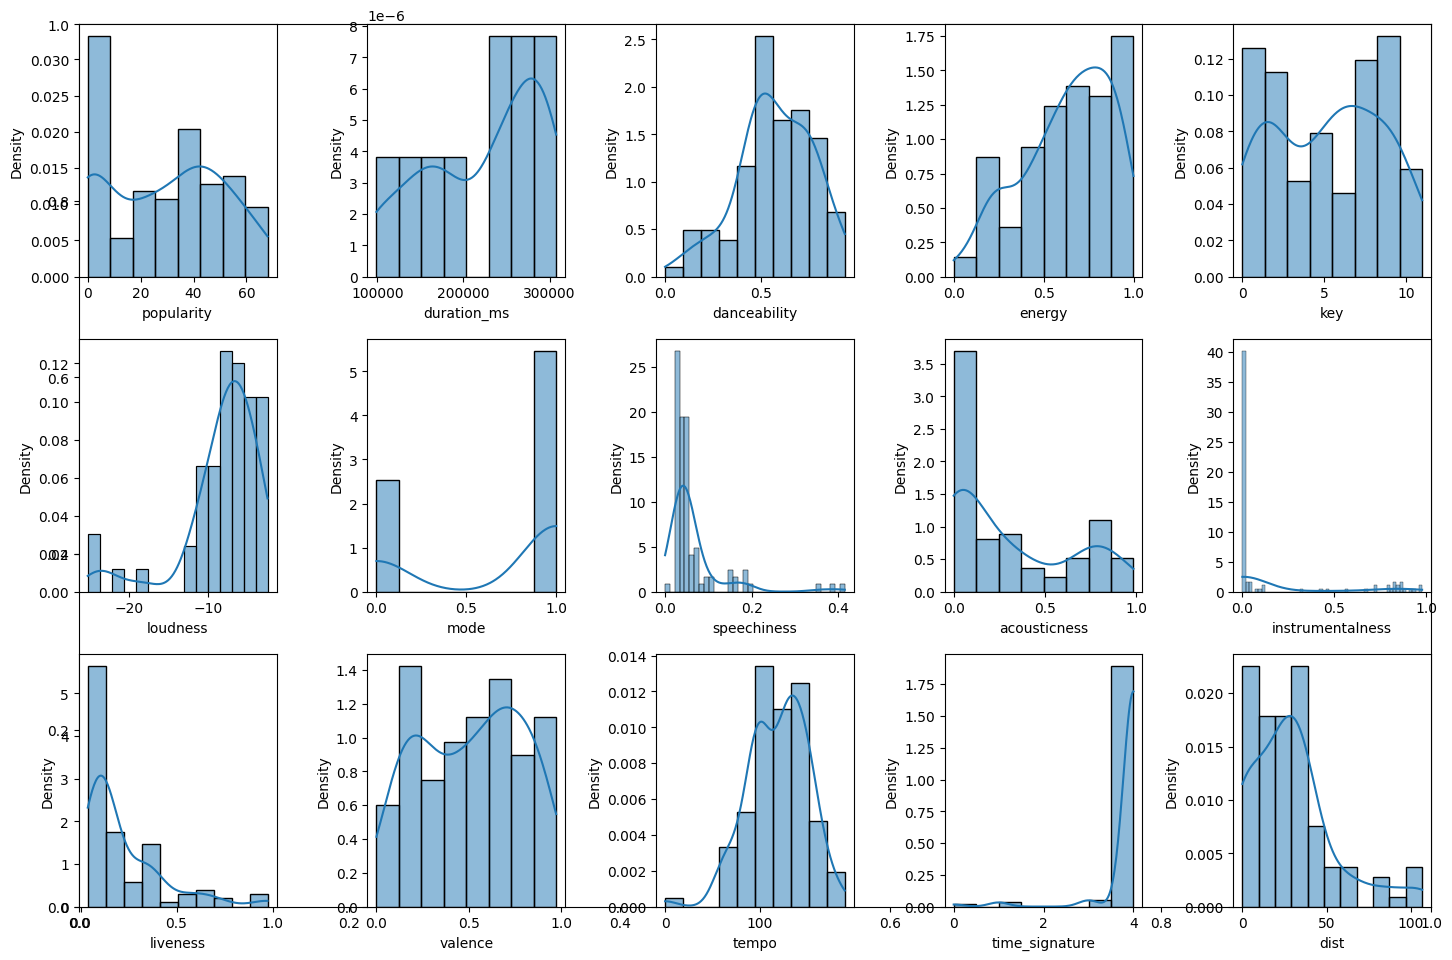

In [52]:
create_distplots_array(results_10_df, dist_cols)

### Prediction pairplot against distance
With average of query songs marked by vertical line 

query songs averages

In [57]:
results_10_df_avg = results_10_df[results_10_df['is_query'] == 1][dist_cols].mean()

In [58]:
results_10_df_avg

popularity              27.9
duration_ms         222961.9
danceability          0.5575
energy              0.646302
key                      4.9
loudness             -9.1574
mode                     0.7
speechiness            0.055
acousticness        0.248163
instrumentalness    0.205485
liveness             0.28413
valence               0.4576
tempo               108.8655
time_signature           3.6
dist                     0.0
dtype: object

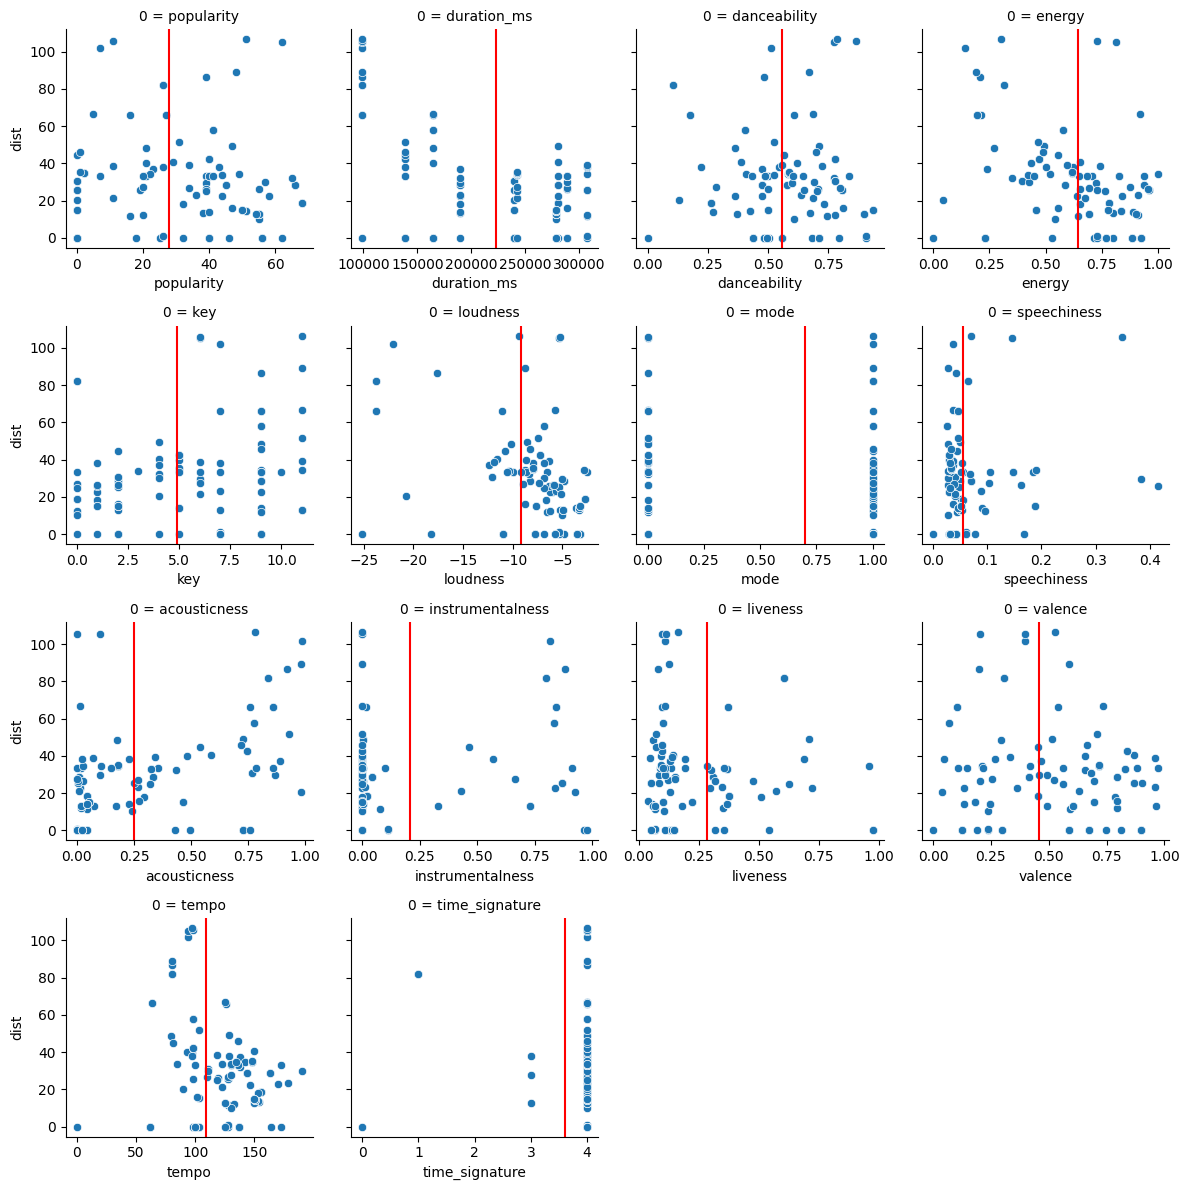

In [67]:
dist_cols_no_dist = [c for c in dist_cols if c != 'dist']
g = sns.FacetGrid(pd.DataFrame(dist_cols_no_dist), col=0, col_wrap=4, sharex=False)
for ax, x_var in zip(g.axes, dist_cols_no_dist):
    sns.scatterplot(data=results_10_df, x=x_var, y='dist', ax=ax)
    ax.axvline(results_10_df_avg[x_var], 0, 100, color='r')
g.tight_layout()
plt.show()
# pp = sns.pairplot(data = results_10_df,
#                   y_vars = ['dist'],
#                   x_vars = )

### Distplot for 50 songs similar to ONE song

In [69]:
sample_songs, sample_songs_names, sample_songs_idx = sample_n_songs(df_eng, 10)
sample_onesong_50_idx = sample_songs_idx[0]
results_onesong_50_df = pd.DataFrame()

results_onesong_50_df = query_by_song(sample_onesong_50_idx, df_eng, numerical_cols, 50)
results_onesong_50_df = results_onesong_50_df.reset_index(drop=True)

Querying:
3052 Something In The Way
idx: 44000, track: Something In The Way, dist: 0.0
idx: 91255, track: Something In The Way, dist: 0.0
idx: 2006, track: Something In The Way, dist: 0.0
idx: 53912, track: Papaoutai, dist: 12.65966003808949
idx: 65502, track: Love Talk - English Version, dist: 13.581592631204927
idx: 21162, track: Diana, dist: 18.16510859644956
idx: 11643, track: Here I Go Again - Radio Mix, dist: 26.009388774673273
idx: 80754, track: Shish Nawata Hoon, dist: 29.894175166577185
idx: 65201, track: Shish Nawata Hoon, dist: 29.894175166577185
idx: 23303, track: Define, dist: 31.798109458547124
idx: 43250, track: Define, dist: 31.798109458547124
idx: 55465, track: Closer X Channa Mereya, dist: 31.878973846094862
idx: 44415, track: Battleships, dist: 36.25786680225411
idx: 97821, track: Leva Minha Timidez, dist: 37.51512912732675
idx: 40898, track: Deus Tremendo (feat. Vanilda Bordieri, Eliane Silva, Lydia Moisés, Suelen de Jesus, Célia Sakamoto, Elaine Martins & Shirley C

In [94]:
results_onesong_50_df.to_csv('results_onesong_50.csv')

In [75]:
results_onesong = results_onesong_50_df[results_onesong_50_df['is_query'] == 1]

In [73]:
results_onesong['dist']

0    0.0
Name: dist, dtype: float64

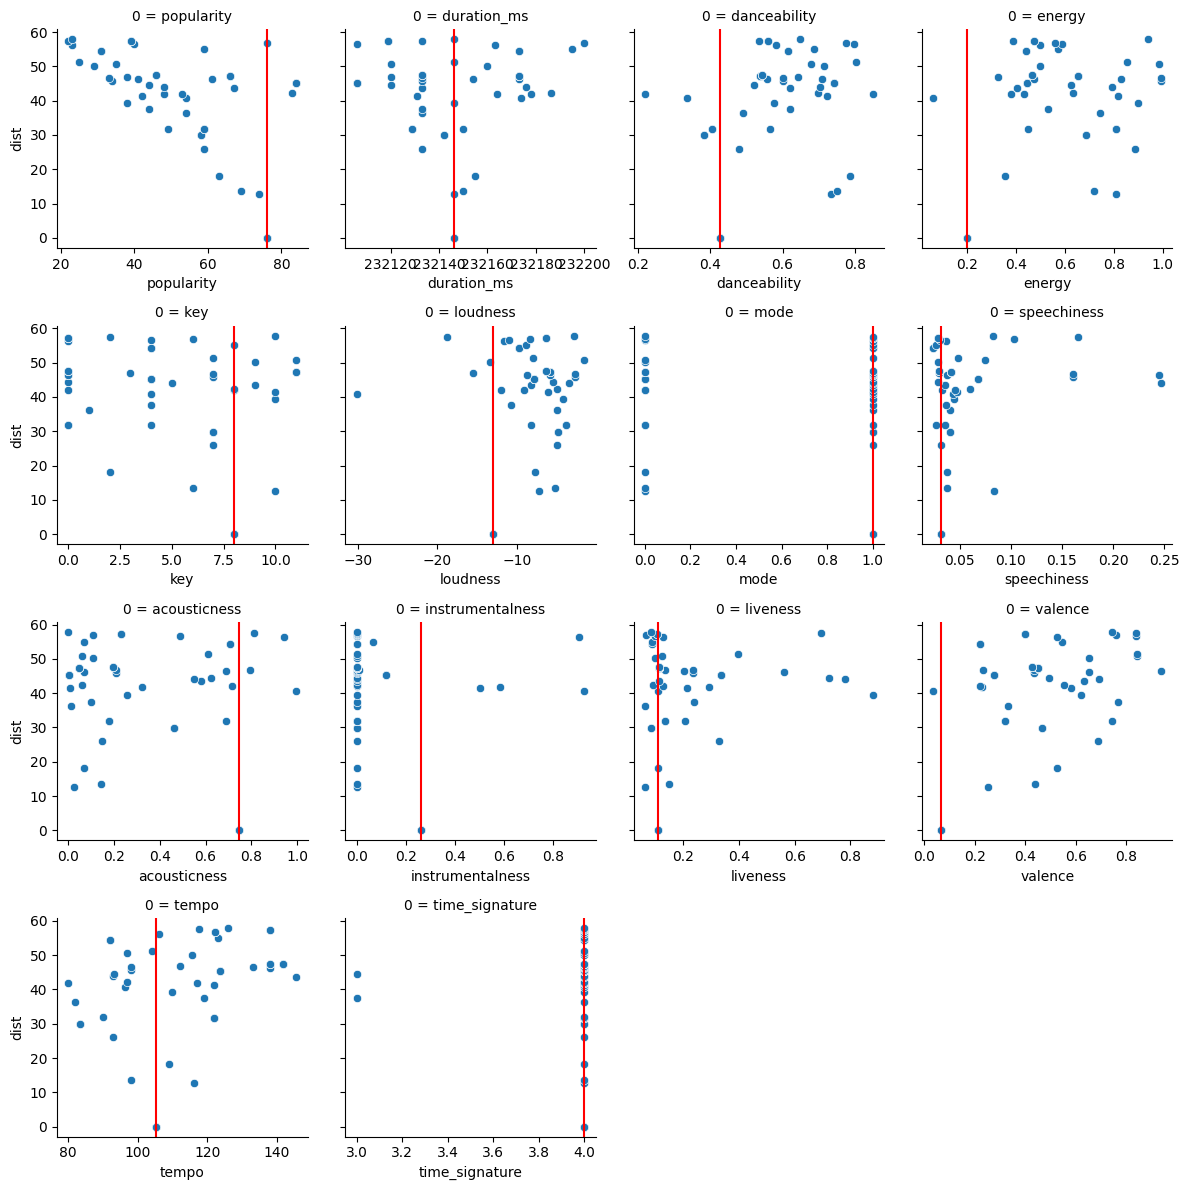

In [84]:
dist_cols_no_dist = [c for c in dist_cols if c != 'dist']
g = sns.FacetGrid(pd.DataFrame(dist_cols_no_dist), col=0, col_wrap=4, sharex=False)
for ax, x_var in zip(g.axes, dist_cols_no_dist):
    sns.scatterplot(data=results_onesong_50_df, x=x_var, y='dist', ax=ax)
    ax.axvline(results_onesong[x_var].values, 0, 100, color='r')
g.tight_layout()
plt.show()
# pp = sns.pairplot(data = results_10_df,
#                   y_vars = ['dist'],
#                   x_vars = )

In [85]:
results_onesong

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,...,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre,dist,is_query
0,4gHnSNHs8RyVukKoWdS99f,Nirvana,Nevermind (Remastered),Something In The Way,76,232146,0,0.427,0.201,8,...,0.0317,0.745,0.263,0.109,0.0668,105.218,4,alternative,0.0,1


Very interesting results, it seems that in the case of factors like popularity, valence, danceability the further we move from the query song's metrics, the higher the distance gets. Such clear relations cannot be observed for many of the other factors.
Perhaps it is worth considering standardizing the factors to a single scale range, such as 0-1, to eliminate any biases related to innate differences in scale.

### StandardScaler before querying

In [91]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
standard_scaler = StandardScaler()
min_max_scaler = MinMaxScaler()

df_eng_scaled = df_eng.copy()

df_eng_scaled[[*numerical_cols]] = standard_scaler.fit_transform(df_eng[[*numerical_cols]])

In [93]:
df_eng_scaled.sample(5)

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
11079,1hFAp8hA8QaSCSZtw9MHQy,Richard Harvey,Hans Zimmer: Epic Scores,Kyrie For The Magdalene,-0.728040,0.067056,0,-2.188522,-2.021172,-0.929534,-2.918686,-1.326297,-0.408128,2.027221,2.303145,-0.538689,-1.693150,0.471987,-6.712656,british
63379,5oZ0VS1ppSqmHywxgfjo4j,PornoGraffitti,WORLDILLIA,Mugen,0.123792,0.246001,0,0.174018,1.234914,0.474967,0.629894,-1.326297,-0.363676,-0.666144,-0.504115,0.328012,1.639027,-0.908618,0.221824,j-rock
34311,7yhvflcXyqw1pQgCSnelZ4,Raghu Dixit,Antaragni - The Fire Within,Gudugudiya Sedi Nodo,0.303126,0.624237,0,0.629239,0.590853,-0.929534,0.639438,-1.326297,-0.340977,0.231845,-0.504101,-0.730413,0.169459,-0.907717,0.221824,folk
110058,5gXKDmafOQ8i4lYr62wxTk,Astrix,He.art,Deep Jungle Walk,1.110125,3.053927,0,0.295026,0.968543,0.194067,-0.017507,-1.326297,-0.371242,-0.945050,1.117571,0.821768,-1.423536,0.529763,0.221824,trance
113394,20ByU9GDZOICvcMQfBWGtj,Hillsong Worship;Brooke Ligertwood,Team Night,Eagle's Wings - Live at Team Night,0.527292,-0.298336,0,-0.845908,-1.528187,-1.491334,-0.736489,0.753979,-0.526351,1.383652,-0.504106,-0.564952,-1.361822,-0.998050,2.533318,world-music


In [95]:
sample_songs, sample_songs_names, sample_songs_idx = sample_n_songs(df_eng_scaled, 10)
sample_onesong_50_idx = sample_songs_idx[0]
results_onesong_50_scaled_df = pd.DataFrame()

results_onesong_50_scaled_df = query_by_song(sample_onesong_50_idx, df_eng_scaled, numerical_cols, 50)
results_onesong_50_scaled_df = results_onesong_50_scaled_df.reset_index(drop=True)

results_onesong_scaled = results_onesong_50_scaled_df[results_onesong_50_scaled_df['is_query'] == 1]

Querying:
47258 Wild World - 2009 Remastered Version
idx: 71466, track: Wild World - 2009 Remastered Version, dist: 0.0
idx: 39554, track: Sun Goes Down (feat. Jasmine Thompson) - Radio Mix, dist: 0.9227620942180259
idx: 99573, track: Run To You, dist: 0.9882679525501664
idx: 102574, track: Run To You, dist: 0.9882679525501664
idx: 31877, track: I Really Like You, dist: 1.055001240697125
idx: 36179, track: Souvenir, dist: 1.059608231287974
idx: 81204, track: Chauffeur, dist: 1.0710884686295283
idx: 80055, track: Chauffeur, dist: 1.0710884686295283
idx: 65885, track: Moon, dist: 1.1307379390044316
idx: 62150, track: 色香水, dist: 1.1329131112719852
idx: 106509, track: SOS, dist: 1.1506163019552789
idx: 83124, track: Anywhere With You, dist: 1.1515009265854683
idx: 53920, track: Anywhere With You, dist: 1.1515009265854683
idx: 25417, track: Xanadu, dist: 1.156052019739314
idx: 82202, track: Sweetness, dist: 1.1599197842169564
idx: 58119, track: What Do They Know?, dist: 1.1655252272977272
i

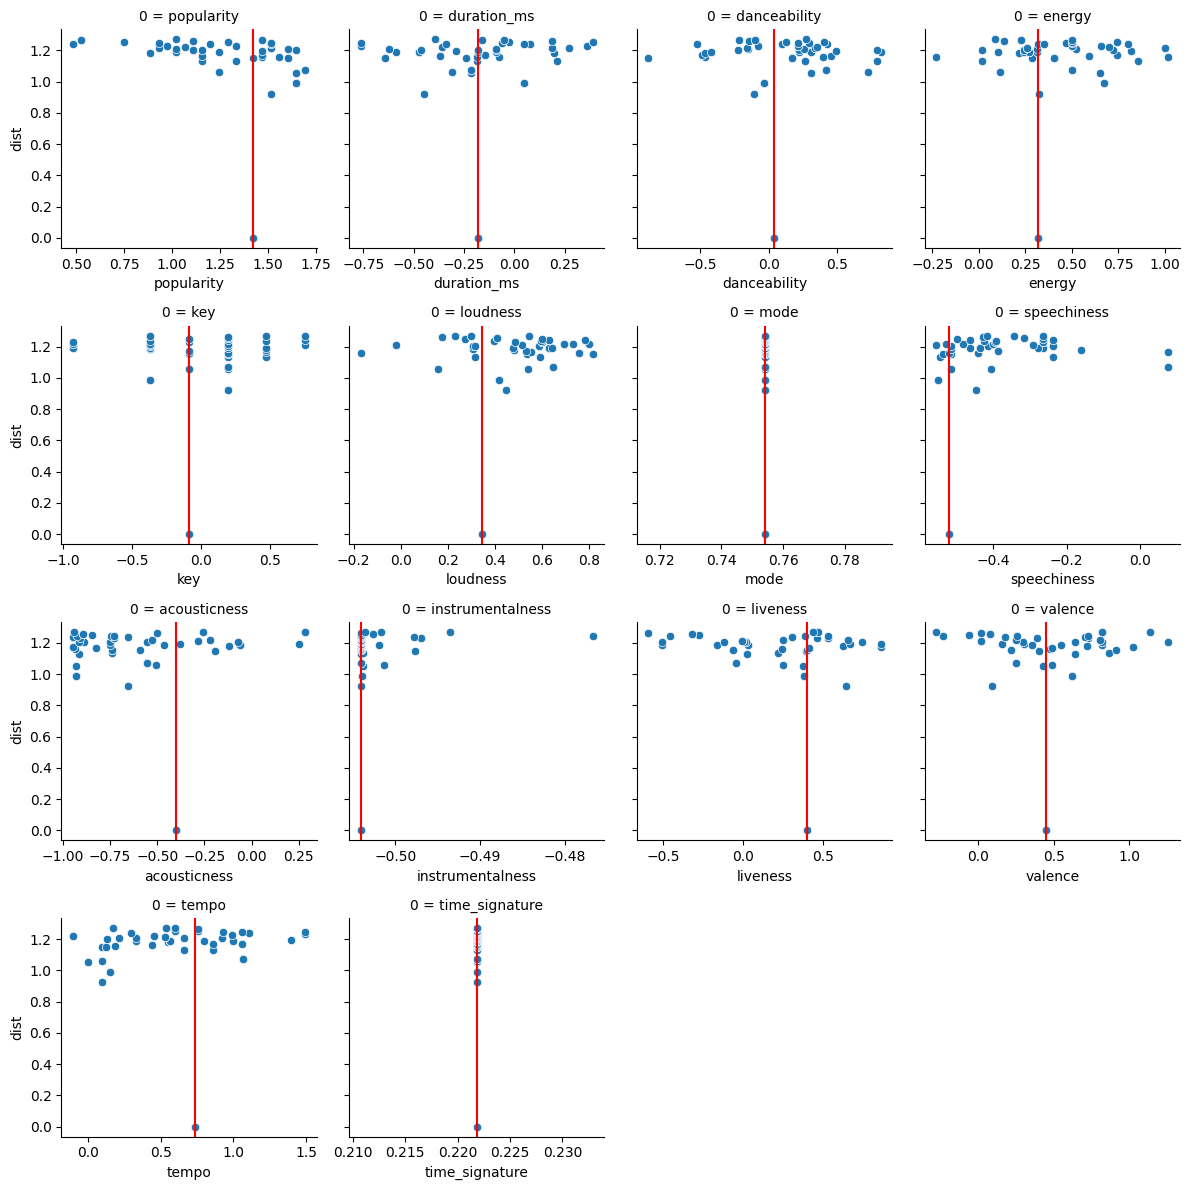

In [96]:
dist_cols_no_dist = [c for c in dist_cols if c != 'dist']
g = sns.FacetGrid(pd.DataFrame(dist_cols_no_dist), col=0, col_wrap=4, sharex=False)
for ax, x_var in zip(g.axes, dist_cols_no_dist):
    sns.scatterplot(data=results_onesong_50_scaled_df, x=x_var, y='dist', ax=ax)
    ax.axvline(results_onesong_scaled[x_var].values, 0, 100, color='r')
g.tight_layout()
plt.show()

It seems scaling did not help at all. Quite the opposite in fact, Almost all of the distances are now equally high, instead of seeign some variance. Why could this be? Scaling should not have removed the relations between the factors and their inner variances and directions, yet it seems that some of the original factors with higher ranges did in fact allow for finding more "directed", closer similarity vectors

### TODO: Visualize relations between song parameters, group by genre itd
### TODO: Classify for genre etc

### Resources / Links:
* https://www.datacamp.com/blog/what-is-similarity-learning
* https://www.youtube.com/watch?v=gaZKjAKfe0s
* https://github.com/IbraheemTaha/Song_Similarity_ForestLSH/blob/master/SongSimilarity.py
* https://medium.com/@Alexander.Bricken/finding-the-next-best-songs-with-machine-learning-55ca9c1511a9
* https://medium.com/wearesinch/searching-for-similar-songs-on-spotify-data-science-c7e3faeb66f0
* https://www.kaggle.com/code/leomauro/spotify-songs-similarity-search/notebook
* https://machinelearninggeek.com/spotify-song-recommender-system-in-python/
* https://towardsdatascience.com/discovering-similarities-across-my-spotify-music-using-data-clustering-and-visualization-52b58e6f547b
* https://www.geeksforgeeks.org/music-recommendation-system-using-machine-learning/
* https://thecleverprogrammer.com/2023/07/31/music-recommendation-system-using-python/